# Walmart Sales Forecasting - Feature Engineering

## Overview
This notebook focuses on data preprocessing and advanced feature engineering for the Walmart Sales dataset:
- Data cleaning and preprocessing
- Time-based feature creation
- Lag and rolling window features
- External feature engineering
- Store and department features
- Holiday and seasonal features

## Feature Engineering Strategy
1. **Temporal Features**: Day, week, month, quarter, year, holidays
2. **Lag Features**: Sales from previous weeks (1, 2, 4, 8, 12 weeks)
3. **Rolling Statistics**: Moving averages, std, min, max over different windows
4. **Store Features**: Size, type, historical performance
5. **Department Features**: Category performance, seasonality
6. **External Features**: Economic indicators, weather, fuel prices
7. **Interaction Features**: Store-department combinations, seasonal interactions

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import os
import sys
from pathlib import Path

# Add project src to path
sys.path.append(str(Path('../src').resolve()))

# Import project modules
from data.data_loader import DataLoader
from utils.config import (
    PROCESSED_DATA_DIR, FEATURE_CONFIG, MODEL_CONFIG
)
from utils.logger import get_project_logger

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Initialize logger
logger = get_project_logger('feature_engineering')

print("Libraries and project modules imported successfully!")

Libraries and project modules imported successfully!


## 1. Data Loading and Initial Preprocessing

In [21]:
# Load datasets using our professional data loader
print("Loading datasets...")
try:
    # Use DataLoader class for professional data loading
    loader = DataLoader()
    train_df, test_df, features_df, stores_df = loader.load_raw_data()
    logger.info('Data loaded successfully using DataLoader')
except (ImportError, NameError):
    # Fallback to direct loading if imports fail in notebook environment
    print('Using direct CSV loading...')
    train_df = pd.read_csv('../data/raw/train.csv')
    features_df = pd.read_csv('../data/raw/features.csv')
    stores_df = pd.read_csv('../data/raw/stores.csv')
    test_df = pd.read_csv('../data/raw/test.csv')
    
    # Convert date columns
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])

print(f"Train shape: {train_df.shape}")
print(f"Features shape: {features_df.shape}")
print(f"Stores shape: {stores_df.shape}")
print(f"Test shape: {test_df.shape}")

# Date ranges
print(f"\nTrain date range: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Test date range: {test_df['Date'].min()} to {test_df['Date'].max()}")

Loading datasets...
2025-08-07 18:05:32 - sales_forecasting.data_loader - INFO - Loading raw datasets...
2025-08-07 18:05:32 - sales_forecasting.data_loader - INFO - Raw data loaded successfully:
2025-08-07 18:05:32 - sales_forecasting.data_loader - INFO -   Train: (421570, 5)
2025-08-07 18:05:32 - sales_forecasting.data_loader - INFO -   Test: (115064, 4)
2025-08-07 18:05:32 - sales_forecasting.data_loader - INFO -   Features: (8190, 12)
2025-08-07 18:05:32 - sales_forecasting.data_loader - INFO -   Stores: (45, 3)
2025-08-07 18:05:32 - sales_forecasting.feature_engineering - INFO - Data loaded successfully using DataLoader
Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)
Test shape: (115064, 4)

Train date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Test date range: 2012-11-02 00:00:00 to 2013-07-26 00:00:00


In [22]:
# Merge datasets
print("Merging datasets...")

# Merge train with stores
train_merged = train_df.merge(stores_df, on='Store', how='left')
print(f"After merging with stores: {train_merged.shape}")

# Merge with features
train_merged = train_merged.merge(features_df, on=['Store', 'Date'], how='left')
print(f"After merging with features: {train_merged.shape}")

# Check merge quality
print(f"\nMissing values after merge:")
missing_counts = train_merged.isnull().sum()
missing_pct = (missing_counts / len(train_merged)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Pct': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

Merging datasets...
After merging with stores: (421570, 7)
After merging with features: (421570, 17)

Missing values after merge:
           Missing_Count  Missing_Pct
MarkDown2         310322    73.611025
MarkDown4         286603    67.984676
MarkDown3         284479    67.480845
MarkDown1         270889    64.257181
MarkDown5         270138    64.079038


## 2. Data Cleaning and Preprocessing

In [23]:
# Handle missing values
print("Handling missing values...")

# For markdown columns, fill with 0 (no markdown)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in train_merged.columns:
        train_merged[col] = train_merged[col].fillna(0)
        print(f"Filled {col} missing values with 0")

# For other numerical features, use forward fill then backward fill
numerical_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in numerical_cols:
    if col in train_merged.columns:
        # Group by store and forward/backward fill
        train_merged[col] = train_merged.groupby('Store')[col].fillna(method='ffill').fillna(method='bfill')
        
        # If still missing, fill with median
        if train_merged[col].isnull().sum() > 0:
            median_val = train_merged[col].median()
            train_merged[col] = train_merged[col].fillna(median_val)
            print(f"Filled remaining {col} missing values with median: {median_val:.2f}")

print(f"\nMissing values after cleaning: {train_merged.isnull().sum().sum()}")

Handling missing values...
Filled MarkDown1 missing values with 0
Filled MarkDown2 missing values with 0
Filled MarkDown3 missing values with 0
Filled MarkDown4 missing values with 0
Filled MarkDown5 missing values with 0

Missing values after cleaning: 0


In [24]:
# Handle negative sales and outliers
print("Handling negative sales and outliers...")

# Analyze negative sales
negative_sales = train_merged[train_merged['Weekly_Sales'] < 0]
print(f"Negative sales records: {len(negative_sales)} ({len(negative_sales)/len(train_merged)*100:.2f}%)")

if len(negative_sales) > 0:
    print(f"Negative sales range: ${negative_sales['Weekly_Sales'].min():,.2f} to ${negative_sales['Weekly_Sales'].max():,.2f}")
    
    # Option 1: Keep negative sales as they represent returns/refunds
    # Option 2: Set to 0 or remove
    # For now, we'll keep them as they're business reality
    print("Keeping negative sales as they represent returns/refunds")

# Identify extreme outliers (beyond 3 standard deviations)
sales_mean = train_merged['Weekly_Sales'].mean()
sales_std = train_merged['Weekly_Sales'].std()
outlier_threshold = sales_mean + 3 * sales_std

outliers = train_merged[train_merged['Weekly_Sales'] > outlier_threshold]
print(f"\nExtreme positive outliers (>3σ): {len(outliers)} ({len(outliers)/len(train_merged)*100:.2f}%)")
if len(outliers) > 0:
    print(f"Outlier range: ${outliers['Weekly_Sales'].min():,.2f} to ${outliers['Weekly_Sales'].max():,.2f}")
    print("Keeping outliers for now - they may represent legitimate high sales periods")

Handling negative sales and outliers...
Negative sales records: 1285 (0.30%)
Negative sales range: $-4,988.94 to $-0.02
Keeping negative sales as they represent returns/refunds

Extreme positive outliers (>3σ): 8848 (2.10%)
Outlier range: $84,118.68 to $693,099.36
Keeping outliers for now - they may represent legitimate high sales periods


## 3. Temporal Feature Engineering

In [25]:
# Create comprehensive temporal features
print("Creating temporal features...")

# Basic time features
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
train_merged['DayOfYear'] = train_merged['Date'].dt.dayofyear
train_merged['Quarter'] = train_merged['Date'].dt.quarter
train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week

# Cyclical features (sine/cosine encoding for periodicity)
train_merged['Month_sin'] = np.sin(2 * np.pi * train_merged['Month'] / 12)
train_merged['Month_cos'] = np.cos(2 * np.pi * train_merged['Month'] / 12)
train_merged['Week_sin'] = np.sin(2 * np.pi * train_merged['WeekOfYear'] / 52)
train_merged['Week_cos'] = np.cos(2 * np.pi * train_merged['WeekOfYear'] / 52)

# Days since start of dataset
start_date = train_merged['Date'].min()
train_merged['Days_Since_Start'] = (train_merged['Date'] - start_date).dt.days

print(f"Created temporal features. Dataset shape: {train_merged.shape}")
print(f"New temporal columns: {[col for col in train_merged.columns if any(x in col.lower() for x in ['year', 'month', 'week', 'quarter', 'day', 'sin', 'cos'])]}")

Creating temporal features...
Created temporal features. Dataset shape: (421570, 28)
New temporal columns: ['Weekly_Sales', 'IsHoliday_x', 'IsHoliday_y', 'Year', 'Month', 'Week', 'DayOfYear', 'Quarter', 'WeekOfYear', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Days_Since_Start']


In [26]:
# Holiday and special event features
print("Creating holiday and special event features...")

# Enhanced holiday features
train_merged['IsHoliday_int'] = train_merged['IsHoliday_x'].astype(int)

# Identify specific holidays based on dates
def identify_holidays(date):
    """Identify specific holidays based on date"""
    month = date.month
    day = date.day
    
    # Major US holidays that affect retail
    if month == 11 and day >= 22 and day <= 28:  # Thanksgiving week
        return 'Thanksgiving'
    elif month == 12 and day >= 20:  # Christmas season
        return 'Christmas'
    elif month == 1 and day <= 7:  # New Year
        return 'NewYear'
    elif month == 2 and day >= 10 and day <= 16:  # Valentine's Day week
        return 'Valentine'
    elif month == 7 and day >= 1 and day <= 7:  # Independence Day
        return 'July4th'
    elif month == 9 and day >= 1 and day <= 7:  # Labor Day
        return 'LaborDay'
    else:
        return 'Regular'

train_merged['Holiday_Type'] = train_merged['Date'].apply(identify_holidays)

# Days to/from major holidays
def days_to_holiday(date, holiday_month, holiday_day_range):
    """Calculate days to nearest holiday"""
    year = date.year
    holiday_date = datetime(year, holiday_month, holiday_day_range[0])
    
    # Check current year and next year
    days_to = (holiday_date - date).days
    if days_to < -30:  # If holiday passed, check next year
        holiday_date = datetime(year + 1, holiday_month, holiday_day_range[0])
        days_to = (holiday_date - date).days
    
    return days_to

# Days to Christmas
train_merged['Days_To_Christmas'] = train_merged['Date'].apply(
    lambda x: days_to_holiday(x, 12, [25])
)

# Days to Thanksgiving (4th Thursday of November - approximate as Nov 25)
train_merged['Days_To_Thanksgiving'] = train_merged['Date'].apply(
    lambda x: days_to_holiday(x, 11, [25])
)

print(f"Holiday features created. Holiday type distribution:")
print(train_merged['Holiday_Type'].value_counts())

Creating holiday and special event features...
Holiday features created. Holiday type distribution:
Holiday_Type
Regular         371234
Christmas        11929
Valentine         8895
LaborDay          8841
July4th           8809
Thanksgiving      5959
NewYear           5903
Name: count, dtype: int64


## 4. Lag Features and Rolling Statistics

In [27]:
# Sort data for lag feature creation
print("Creating lag features and rolling statistics...")
train_merged = train_merged.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Define lag periods (in weeks)
lag_periods = [1, 2, 4, 8, 12, 26]  # 1 week to 6 months
rolling_windows = [4, 8, 12, 26]    # 1 month to 6 months

print(f"Creating lag features for periods: {lag_periods}")
print(f"Creating rolling statistics for windows: {rolling_windows}")

# Create lag features
for lag in lag_periods:
    print(f"Creating lag {lag} features...")
    
    # Sales lag
    train_merged[f'Sales_Lag_{lag}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)
    
    # Store-level sales lag (aggregated across departments)
    store_sales = train_merged.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
    store_sales = store_sales.sort_values(['Store', 'Date'])
    store_sales[f'Store_Sales_Lag_{lag}'] = store_sales.groupby('Store')['Weekly_Sales'].shift(lag)
    
    # Merge back
    train_merged = train_merged.merge(
        store_sales[['Store', 'Date', f'Store_Sales_Lag_{lag}']], 
        on=['Store', 'Date'], 
        how='left'
    )

print(f"Lag features created. Dataset shape: {train_merged.shape}")

Creating lag features and rolling statistics...
Creating lag features for periods: [1, 2, 4, 8, 12, 26]
Creating rolling statistics for windows: [4, 8, 12, 26]
Creating lag 1 features...
Creating lag 2 features...
Creating lag 4 features...
Creating lag 8 features...
Creating lag 12 features...
Creating lag 26 features...
Lag features created. Dataset shape: (421570, 44)


In [28]:
# Create rolling statistics
for window in rolling_windows:
    print(f"Creating rolling statistics for window {window}...")
    
    # Rolling mean
    train_merged[f'Sales_Rolling_Mean_{window}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    # Rolling standard deviation
    train_merged[f'Sales_Rolling_Std_{window}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    
    # Rolling min and max
    train_merged[f'Sales_Rolling_Min_{window}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )
    
    train_merged[f'Sales_Rolling_Max_{window}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    
    # Exponential weighted moving average
    train_merged[f'Sales_EWM_{window}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.ewm(span=window).mean()
    )

print(f"Rolling statistics created. Dataset shape: {train_merged.shape}")

Creating rolling statistics for window 4...
Creating rolling statistics for window 8...
Creating rolling statistics for window 12...
Creating rolling statistics for window 26...
Rolling statistics created. Dataset shape: (421570, 64)


## 5. Store and Department Features

In [29]:
# Store-level features
print("Creating store and department features...")

# Store performance metrics
store_stats = train_merged.groupby('Store')['Weekly_Sales'].agg([
    'mean', 'std', 'min', 'max', 'median'
]).reset_index()
store_stats.columns = ['Store', 'Store_Avg_Sales', 'Store_Std_Sales', 
                      'Store_Min_Sales', 'Store_Max_Sales', 'Store_Median_Sales']

# Store coefficient of variation
store_stats['Store_CV'] = store_stats['Store_Std_Sales'] / store_stats['Store_Avg_Sales']

# Store size per square foot sales
store_stats = store_stats.merge(stores_df, on='Store')
store_stats['Sales_Per_SqFt'] = store_stats['Store_Avg_Sales'] / store_stats['Size']

# Merge back to main dataset
train_merged = train_merged.merge(
    store_stats[['Store', 'Store_Avg_Sales', 'Store_Std_Sales', 'Store_CV', 'Sales_Per_SqFt']], 
    on='Store', 
    how='left'
)

print(f"Store features created. Dataset shape: {train_merged.shape}")

Creating store and department features...
Store features created. Dataset shape: (421570, 68)


In [30]:
# Department-level features
dept_stats = train_merged.groupby('Dept')['Weekly_Sales'].agg([
    'mean', 'std', 'min', 'max', 'median', 'count'
]).reset_index()
dept_stats.columns = ['Dept', 'Dept_Avg_Sales', 'Dept_Std_Sales', 
                     'Dept_Min_Sales', 'Dept_Max_Sales', 'Dept_Median_Sales', 'Dept_Record_Count']

# Department coefficient of variation
dept_stats['Dept_CV'] = dept_stats['Dept_Std_Sales'] / dept_stats['Dept_Avg_Sales']

# Department seasonality (variance across months)
dept_seasonality = train_merged.groupby(['Dept', 'Month'])['Weekly_Sales'].mean().reset_index()
dept_seasonality_var = dept_seasonality.groupby('Dept')['Weekly_Sales'].var().reset_index()
dept_seasonality_var.columns = ['Dept', 'Dept_Seasonal_Variance']

# Merge department features
dept_stats = dept_stats.merge(dept_seasonality_var, on='Dept')

train_merged = train_merged.merge(
    dept_stats[['Dept', 'Dept_Avg_Sales', 'Dept_Std_Sales', 'Dept_CV', 'Dept_Seasonal_Variance']], 
    on='Dept', 
    how='left'
)

print(f"Department features created. Dataset shape: {train_merged.shape}")

Department features created. Dataset shape: (421570, 72)


## 6. External Feature Engineering

In [31]:
# External feature engineering
print("Engineering external features...")

# Temperature features
if 'Temperature' in train_merged.columns:
    # Temperature categories
    train_merged['Temp_Category'] = pd.cut(train_merged['Temperature'], 
                                          bins=[-np.inf, 32, 50, 70, 85, np.inf], 
                                          labels=['Freezing', 'Cold', 'Cool', 'Warm', 'Hot'])
    
    # Temperature change from previous week
    train_merged['Temp_Change'] = train_merged.groupby('Store')['Temperature'].diff()
    
    # Seasonal temperature deviation
    monthly_temp_avg = train_merged.groupby(['Store', 'Month'])['Temperature'].mean().reset_index()
    monthly_temp_avg.columns = ['Store', 'Month', 'Monthly_Avg_Temp']
    train_merged = train_merged.merge(monthly_temp_avg, on=['Store', 'Month'], how='left')
    train_merged['Temp_Deviation'] = train_merged['Temperature'] - train_merged['Monthly_Avg_Temp']

# Fuel price features
if 'Fuel_Price' in train_merged.columns:
    # Fuel price change
    train_merged['Fuel_Price_Change'] = train_merged.groupby('Store')['Fuel_Price'].diff()
    
    # Fuel price volatility (rolling std)
    train_merged['Fuel_Price_Volatility'] = train_merged.groupby('Store')['Fuel_Price'].transform(
        lambda x: x.rolling(window=4, min_periods=1).std()
    )

# Economic indicators
if 'CPI' in train_merged.columns:
    # CPI change (inflation indicator)
    train_merged['CPI_Change'] = train_merged.groupby('Store')['CPI'].diff()
    
if 'Unemployment' in train_merged.columns:
    # Unemployment change
    train_merged['Unemployment_Change'] = train_merged.groupby('Store')['Unemployment'].diff()
    
    # Unemployment category
    train_merged['Unemployment_Category'] = pd.cut(train_merged['Unemployment'], 
                                                  bins=[0, 5, 7.5, 10, np.inf], 
                                                  labels=['Low', 'Medium', 'High', 'Very_High'])

print(f"External features created. Dataset shape: {train_merged.shape}")

Engineering external features...
External features created. Dataset shape: (421570, 81)


## 7. Interaction and Advanced Features

In [32]:
# Create interaction features
print("Creating interaction and advanced features...")

# Store-Department interaction
train_merged['Store_Dept_ID'] = train_merged['Store'].astype(str) + '_' + train_merged['Dept'].astype(str)

# Store type and size interaction
train_merged['Type_Size_Interaction'] = train_merged['Type'] + '_' + pd.cut(train_merged['Size'], 
                                                                           bins=3, 
                                                                           labels=['Small', 'Medium', 'Large']).astype(str)

# Holiday and store type interaction
train_merged['Holiday_Type_Interaction'] = train_merged['Holiday_Type'] + '_' + train_merged['Type']

# Seasonal department performance
train_merged['Dept_Quarter_ID'] = train_merged['Dept'].astype(str) + '_Q' + train_merged['Quarter'].astype(str)

# Sales momentum (current vs recent average)
if 'Sales_Rolling_Mean_4' in train_merged.columns:
    train_merged['Sales_Momentum'] = train_merged['Weekly_Sales'] / (train_merged['Sales_Rolling_Mean_4'] + 1)

# Sales volatility indicator
if 'Sales_Rolling_Std_4' in train_merged.columns and 'Sales_Rolling_Mean_4' in train_merged.columns:
    train_merged['Sales_Volatility'] = train_merged['Sales_Rolling_Std_4'] / (train_merged['Sales_Rolling_Mean_4'] + 1)

print(f"Interaction features created. Dataset shape: {train_merged.shape}")

Creating interaction and advanced features...
Interaction features created. Dataset shape: (421570, 87)


## 8. Feature Encoding and Preprocessing

In [33]:
# Encode categorical features
print("Encoding categorical features...")

# Label encoding for ordinal features
label_encoders = {}
ordinal_features = ['Type', 'Holiday_Type', 'Temp_Category', 'Unemployment_Category']

for feature in ordinal_features:
    if feature in train_merged.columns:
        le = LabelEncoder()
        train_merged[f'{feature}_encoded'] = le.fit_transform(train_merged[feature].astype(str))
        label_encoders[feature] = le
        print(f"Label encoded {feature}: {len(le.classes_)} categories")

# One-hot encoding for nominal features (if needed)
nominal_features = ['Store_Dept_ID', 'Type_Size_Interaction', 'Holiday_Type_Interaction', 'Dept_Quarter_ID']

# For high cardinality features, we'll use target encoding or frequency encoding instead of one-hot
for feature in nominal_features:
    if feature in train_merged.columns:
        # Frequency encoding
        freq_map = train_merged[feature].value_counts().to_dict()
        train_merged[f'{feature}_freq'] = train_merged[feature].map(freq_map)
        
        # Target encoding (mean sales by category)
        target_map = train_merged.groupby(feature)['Weekly_Sales'].mean().to_dict()
        train_merged[f'{feature}_target_enc'] = train_merged[feature].map(target_map)
        
        print(f"Frequency and target encoded {feature}: {train_merged[feature].nunique()} unique values")

print(f"Feature encoding completed. Dataset shape: {train_merged.shape}")

Encoding categorical features...
Label encoded Type: 3 categories
Label encoded Holiday_Type: 7 categories
Label encoded Temp_Category: 5 categories
Label encoded Unemployment_Category: 4 categories
Frequency and target encoded Store_Dept_ID: 3331 unique values
Frequency and target encoded Type_Size_Interaction: 6 unique values
Frequency and target encoded Holiday_Type_Interaction: 21 unique values
Frequency and target encoded Dept_Quarter_ID: 324 unique values
Feature encoding completed. Dataset shape: (421570, 99)


## 9. Feature Selection and Validation

In [34]:
# Feature validation and selection
print("Validating features...")

# Check for infinite values
numeric_cols = train_merged.select_dtypes(include=[np.number]).columns
inf_cols = []
for col in numeric_cols:
    if np.isinf(train_merged[col]).any():
        inf_cols.append(col)
        train_merged[col] = train_merged[col].replace([np.inf, -np.inf], np.nan)

if inf_cols:
    print(f"Found and handled infinite values in: {inf_cols}")

# Check for remaining missing values
missing_after_fe = train_merged.isnull().sum()
missing_cols = missing_after_fe[missing_after_fe > 0]
if len(missing_cols) > 0:
    print(f"\nRemaining missing values:")
    for col, count in missing_cols.items():
        print(f"{col}: {count} ({count/len(train_merged)*100:.2f}%)")
    
    # Fill remaining missing values with median for numeric columns
    for col in missing_cols.index:
        if train_merged[col].dtype in ['float64', 'int64']:
            median_val = train_merged[col].median()
            train_merged[col] = train_merged[col].fillna(median_val)
            print(f"Filled {col} with median: {median_val}")
else:
    print("No missing values found after feature engineering!")

# Feature correlation analysis
print("\nAnalyzing feature correlations...")
correlation_with_target = train_merged[numeric_cols].corr()['Weekly_Sales'].abs().sort_values(ascending=False)
print("\nTop 15 features correlated with Weekly_Sales:")
print(correlation_with_target.head(15))

Validating features...
Found and handled infinite values in: ['Sales_Momentum', 'Sales_Volatility']

Remaining missing values:
Sales_Lag_1: 3331 (0.79%)
Store_Sales_Lag_1: 2955 (0.70%)
Sales_Lag_2: 6625 (1.57%)
Store_Sales_Lag_2: 5911 (1.40%)
Sales_Lag_4: 13134 (3.12%)
Store_Sales_Lag_4: 11839 (2.81%)
Sales_Lag_8: 25966 (6.16%)
Store_Sales_Lag_8: 23627 (5.60%)
Sales_Lag_12: 38615 (9.16%)
Store_Sales_Lag_12: 35404 (8.40%)
Sales_Lag_26: 81918 (19.43%)
Store_Sales_Lag_26: 76218 (18.08%)
Sales_Rolling_Std_4: 3331 (0.79%)
Sales_Rolling_Std_8: 3331 (0.79%)
Sales_Rolling_Std_12: 3331 (0.79%)
Sales_Rolling_Std_26: 3331 (0.79%)
Temp_Change: 45 (0.01%)
Fuel_Price_Change: 45 (0.01%)
Fuel_Price_Volatility: 45 (0.01%)
CPI_Change: 45 (0.01%)
Unemployment_Change: 45 (0.01%)
Sales_Momentum: 4 (0.00%)
Sales_Volatility: 3334 (0.79%)
Filled Sales_Lag_1 with median: 7625.99
Filled Store_Sales_Lag_1 with median: 1010326.14
Filled Sales_Lag_2 with median: 7639.58
Filled Store_Sales_Lag_2 with median: 101071

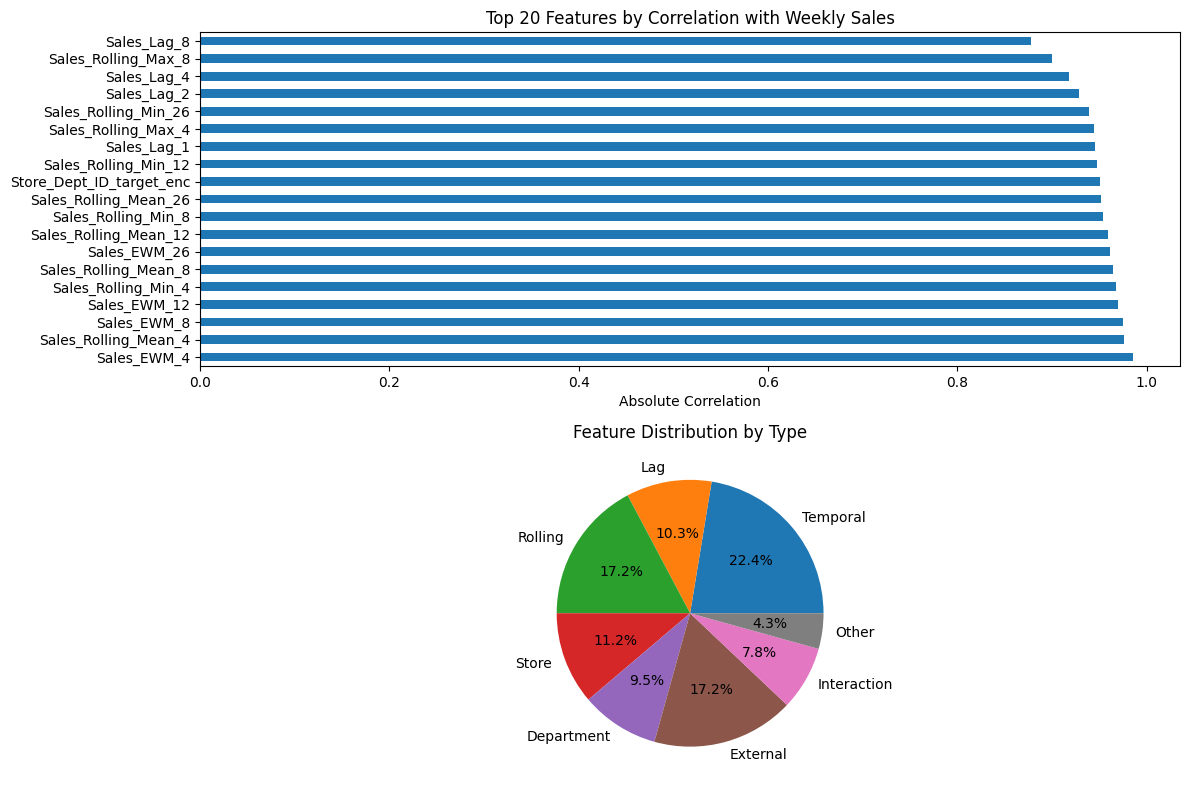


Feature type breakdown:
Temporal: 26 features
Lag: 12 features
Rolling: 20 features
Store: 13 features
Department: 11 features
External: 20 features
Interaction: 9 features
Other: 5 features
Total features: 99


In [35]:
# Feature importance visualization
plt.figure(figsize=(12, 8))

# Top correlations with target
top_features = correlation_with_target.head(20).drop('Weekly_Sales')
plt.subplot(2, 1, 1)
top_features.plot(kind='barh')
plt.title('Top 20 Features by Correlation with Weekly Sales')
plt.xlabel('Absolute Correlation')

# Feature distribution
plt.subplot(2, 1, 2)
feature_types = {
    'Temporal': len([col for col in train_merged.columns if any(x in col.lower() for x in ['year', 'month', 'week', 'quarter', 'day', 'sin', 'cos', 'holiday'])]),
    'Lag': len([col for col in train_merged.columns if 'lag' in col.lower()]),
    'Rolling': len([col for col in train_merged.columns if any(x in col.lower() for x in ['rolling', 'ewm'])]),
    'Store': len([col for col in train_merged.columns if 'store' in col.lower()]),
    'Department': len([col for col in train_merged.columns if 'dept' in col.lower()]),
    'External': len([col for col in train_merged.columns if any(x in col.lower() for x in ['temp', 'fuel', 'cpi', 'unemployment', 'markdown'])]),
    'Interaction': len([col for col in train_merged.columns if any(x in col.lower() for x in ['interaction', 'momentum', 'volatility'])]),
    'Other': len([col for col in train_merged.columns if not any(keyword in col.lower() for keyword in ['year', 'month', 'week', 'quarter', 'day', 'sin', 'cos', 'holiday', 'lag', 'rolling', 'ewm', 'store', 'dept', 'temp', 'fuel', 'cpi', 'unemployment', 'markdown', 'interaction', 'momentum', 'volatility'])])
}

plt.pie(feature_types.values(), labels=feature_types.keys(), autopct='%1.1f%%')
plt.title('Feature Distribution by Type')

plt.tight_layout()
plt.show()

print(f"\nFeature type breakdown:")
for ftype, count in feature_types.items():
    print(f"{ftype}: {count} features")
print(f"Total features: {len(train_merged.columns)}")

## 10. Data Export and Summary

In [36]:
# Prepare final dataset
print("Preparing final dataset for modeling...")

# Create feature list for modeling (exclude non-predictive columns)
exclude_cols = ['Date', 'Weekly_Sales']  # Target and date
categorical_cols = ['Type', 'Holiday_Type', 'Temp_Category', 'Unemployment_Category', 
                   'Store_Dept_ID', 'Type_Size_Interaction', 'Holiday_Type_Interaction', 'Dept_Quarter_ID']
exclude_cols.extend(categorical_cols)  # Exclude original categorical columns (keep encoded versions)

feature_cols = [col for col in train_merged.columns if col not in exclude_cols]

print(f"\nFinal dataset summary:")
print(f"Total records: {len(train_merged):,}")
print(f"Total features: {len(feature_cols)}")
print(f"Date range: {train_merged['Date'].min()} to {train_merged['Date'].max()}")
print(f"Stores: {train_merged['Store'].nunique()}")
print(f"Departments: {train_merged['Dept'].nunique()}")

# Ensure processed data directory exists
os.makedirs('../data/processed', exist_ok=True)

# Save processed dataset
output_path = '../data/processed/train_processed.csv'
train_merged.to_csv(output_path, index=False)
print(f"\nProcessed dataset saved to: {output_path}")

# Save feature list
feature_list_path = '../data/processed/feature_list.txt'
with open(feature_list_path, 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")
print(f"Feature list saved to: {feature_list_path}")

# Save label encoders for future use
import pickle
encoders_path = '../data/processed/label_encoders.pkl'
with open(encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"Label encoders saved to: {encoders_path}")

# Save feature engineering metadata
metadata = {
    'creation_date': datetime.now().isoformat(),
    'total_features': len(feature_cols),
    'total_records': len(train_merged),
    'date_range': [str(train_merged['Date'].min()), str(train_merged['Date'].max())],
    'stores': train_merged['Store'].nunique(),
    'departments': train_merged['Dept'].nunique(),
    'feature_types': feature_types
}

import json
metadata_path = '../data/processed/feature_engineering_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Feature engineering metadata saved to: {metadata_path}")

Preparing final dataset for modeling...

Final dataset summary:
Total records: 421,570
Total features: 89
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45
Departments: 81



Processed dataset saved to: ../data/processed/train_processed.csv
Feature list saved to: ../data/processed/feature_list.txt
Label encoders saved to: ../data/processed/label_encoders.pkl
Feature engineering metadata saved to: ../data/processed/feature_engineering_metadata.json


In [37]:
# Feature engineering summary
print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

print(f"\n📊 Dataset Transformation:")
print(f"   • Original train dataset: {train_df.shape}")
print(f"   • Final processed dataset: {train_merged.shape}")
print(f"   • Features added: {train_merged.shape[1] - train_df.shape[1]}")

print(f"\n🔧 Feature Categories Created:")
for ftype, count in feature_types.items():
    print(f"   • {ftype}: {count} features")

print(f"\n📈 Key Features for Modeling:")
print(f"   • Total modeling features: {len(feature_cols)}")
print(f"   • Numerical features: {len([col for col in feature_cols if train_merged[col].dtype in ['float64', 'int64']])}")
print(f"   • Categorical features: {len([col for col in feature_cols if train_merged[col].dtype == 'object'])}")

print(f"\n✅ Data Quality:")
print(f"   • Missing values: {train_merged[feature_cols].isnull().sum().sum()}")
print(f"   • Infinite values: Handled")
print(f"   • Data types: Validated")

print(f"\n🎯 Ready for Modeling:")
print(f"   • Processed dataset: {output_path}")
print(f"   • Feature list: {feature_list_path}")
print(f"   • Label encoders: {encoders_path}")

print("\n" + "="*60)
print("Feature engineering completed successfully!")
print("Ready to proceed with baseline modeling.")
print("="*60)


FEATURE ENGINEERING SUMMARY

📊 Dataset Transformation:
   • Original train dataset: (421570, 5)
   • Final processed dataset: (421570, 99)
   • Features added: 94

🔧 Feature Categories Created:
   • Temporal: 26 features
   • Lag: 12 features
   • Rolling: 20 features
   • Store: 13 features
   • Department: 11 features
   • External: 20 features
   • Interaction: 9 features
   • Other: 5 features

📈 Key Features for Modeling:
   • Total modeling features: 89
   • Numerical features: 79
   • Categorical features: 0

✅ Data Quality:
   • Missing values: 0
   • Infinite values: Handled
   • Data types: Validated

🎯 Ready for Modeling:
   • Processed dataset: ../data/processed/train_processed.csv
   • Feature list: ../data/processed/feature_list.txt
   • Label encoders: ../data/processed/label_encoders.pkl

Feature engineering completed successfully!
Ready to proceed with baseline modeling.
